In [18]:
import numpy as np
import pandas as pd
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

from gcsfs import GCSFileSystem

In [7]:
meta = pd.read_csv('gap_images/metadata.csv')

meta['id'] = meta['file_id'].str.slice(4,9)
file_key = meta[['id','file_id']]

# we would eventually have this as a database table
file_key_short = file_key[:1000]

#print(file_key_short)

In [8]:
# the resize_bw function is Rohit's code
def resize_bw(image_in, size, img=None, save=False):
    """This functions re-sizes a color/grayscale image into new size and grayscale"""

    image = image_in.convert('L').resize(size)

    if save:
        image.save(PATH_IMAGES_RESIZE_BW + img + '.jpg')
        return None
    else:
        return image

In [9]:
image_folder = 'gap_images/gap_images/'
SIZE = 128, 128
images_array = np.zeros([len(file_key),SIZE[0],SIZE[0],1])

for i in range(len(file_key)):
    image = Image.open(image_folder + file_key['file_id'][i])
    img_bw = resize_bw(image, size=SIZE)
    img_bw = np.asarray(img_bw).reshape((SIZE[0], SIZE[1], 1))
    images_array[i,:,:,:] = img_bw / 255.

    
images_array.shape

(9294, 128, 128, 1)

In [123]:
# train and validation data 
# train on the first 8000 images
images_array_train = images_array[:8000,:,:,:]
images_array_test = images_array[8000:,:,:,:]


In [65]:
images_array_train[53,:5,:5,:]

array([[[0.16078431],
        [0.11764706],
        [0.09803922],
        [0.10196078],
        [0.09019608]],

       [[0.13333333],
        [0.14509804],
        [0.12156863],
        [0.10196078],
        [0.11764706]],

       [[0.12156863],
        [0.08627451],
        [0.1372549 ],
        [0.1254902 ],
        [0.1254902 ]],

       [[0.12156863],
        [0.1372549 ],
        [0.15686275],
        [0.14509804],
        [0.16862745]],

       [[0.14117647],
        [0.1372549 ],
        [0.11764706],
        [0.1372549 ],
        [0.16078431]]])

In [124]:
# Creating the model
input_img = Input(shape=(128, 128, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(input_img,encoded)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')



In [125]:
autoencoder.summary()

Model: "functional_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 16, 16, 8)       

In [126]:
# training the model
autoencoder.fit(images_array_train,images_array_train, epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(images_array_test, images_array_test))
                

Epoch 1/10
32/32 [==============================] - 133s 4s/step - loss: 0.6564 - val_loss: 0.6342
Epoch 2/10
32/32 [==============================] - 134s 4s/step - loss: 0.5963 - val_loss: 0.6022
Epoch 3/10
32/32 [==============================] - 136s 4s/step - loss: 0.5772 - val_loss: 0.5774
Epoch 4/10
32/32 [==============================] - 135s 4s/step - loss: 0.5697 - val_loss: 0.5751
Epoch 5/10
32/32 [==============================] - 134s 4s/step - loss: 0.5675 - val_loss: 0.5737
Epoch 6/10
32/32 [==============================] - 134s 4s/step - loss: 0.5664 - val_loss: 0.5726
Epoch 7/10
32/32 [==============================] - 134s 4s/step - loss: 0.5655 - val_loss: 0.5723
Epoch 8/10
32/32 [==============================] - 134s 4s/step - loss: 0.5646 - val_loss: 0.5712
Epoch 9/10
32/32 [==============================] - 135s 4s/step - loss: 0.5642 - val_loss: 0.5711
Epoch 10/10
32/32 [==============================] - 137s 4s/step - loss: 0.5639 - val_loss: 0.5707


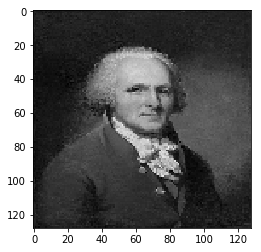

In [106]:
# Examining sample encoding
image = Image.open(image_folder + file_key_short['file_id'][53])
img_bw = resize_bw(image, size=SIZE)
img_bw = np.asarray(img_bw).reshape((SIZE[0], SIZE[1], 1))

img_bw3 = np.zeros([SIZE[0],SIZE[1],3])
for i in range(3):
    img_bw3[:,:,i] = img_bw[:,:,0] / 255.
    
    
#img_bw3.shape

plt.imshow(img_bw3);

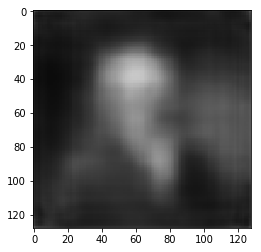

In [127]:
pred = autoencoder.predict(img_bw.reshape([1,128,128,1]) / 255.)

pred.shape

pred_img = np.zeros([SIZE[0],SIZE[1],3])
for i in range(3):
    pred_img[:,:,i] = pred[0,:,:,0]

plt.imshow(pred_img);

In [128]:
enc = encoder.predict(images_array)

In [129]:
enc.shape

(9294, 8, 8, 8)

In [132]:
# saving the model and encoding

encoder.save('conv_encoder.h5')
autoencoder.save('conv_encoder_decoder.h5')

with open('conv_encoding.npy', 'wb') as f1:
    np.save(f1, enc)
    

In [143]:
# Write encodings to Google Cloud bucket - but don't have permission
#gcs = GCSFileSystem(project='practicum1-abnormal-distribution')
#gcs.ls('practicum1-abnormal-distribution/data')
#
#with gcs.open('data/conv_encoding.npy', 'wb') as f2:
#    np.save(f2, enc)

### In order to use the encoded representation:
### - load the model in the conv_encoder.h5 file
### - run the model's predict function on an image prepared as follows:
###     -- 128x128x1 such as created by the resize_bw function
###     -- add an 4th dimension e.g. reshape([1,128,128,1])
###     -- rescale by dividing by 255. so values are between 0 and 1 (and noninteger)

In [23]:
image = Image.open(image_folder + file_key['file_id'][53])
img_bw = resize_bw(image, size=SIZE)
img_bw = np.asarray(img_bw).reshape((SIZE[0], SIZE[1], 1))

conv_encoder = load_model('conv_encoder.h5')
conv_encoder_decoder = load_model('conv_encoder_decoder.h5')

#pred = autoencoder.predict(img_bw.reshape([1,128,128,1]) / 255.)

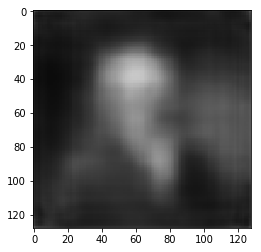

In [25]:
pred = conv_encoder_decoder.predict(img_bw.reshape([1,128,128,1]) / 255.)
pred.shape

pred_img = np.zeros([SIZE[0],SIZE[1],3])
for i in range(3):
    pred_img[:,:,i] = pred[0,:,:,0]

plt.imshow(pred_img);

In [26]:
pred_encoding = conv_encoder.predict(img_bw.reshape([1,128,128,1]) / 255.)

pred_encoding

array([[[[0.268023  , 1.0061646 , 0.        , 0.6802024 , 0.4706757 ,
          0.7527358 , 0.25358295, 0.        ],
         [0.06941168, 1.0088513 , 0.        , 0.66800386, 0.24091704,
          0.7333852 , 0.11133149, 0.        ],
         [0.06687052, 0.9732602 , 0.        , 0.6883022 , 0.21247545,
          0.7355861 , 0.11024286, 0.        ],
         [0.06797476, 0.95053965, 0.        , 0.73899925, 0.19136964,
          0.72957987, 0.12515591, 0.        ],
         [0.06684317, 0.9563502 , 0.        , 0.69751173, 0.1967191 ,
          0.73062104, 0.11944027, 0.        ],
         [0.06497218, 0.9775729 , 0.        , 0.65730274, 0.21126933,
          0.72411036, 0.10804771, 0.        ],
         [0.05753104, 0.9548916 , 0.        , 0.66754854, 0.2060432 ,
          0.7099122 , 0.103701  , 0.        ],
         [0.06459171, 0.95960844, 0.        , 0.66156125, 0.22297248,
          0.83249366, 0.11325949, 0.        ]],

        [[0.11118592, 1.1161201 , 0.        , 0.7243862 , 0.52